## uji coba fine tuning dengan train, val, test data


Class names: ['cassava', 'corn', 'rice', 'sugarcane']
Epoch 1/6
----------
train Loss: 1.3035 Acc: 0.3743
val Loss: 0.9131 Acc: 0.6944
Epoch 2/6
----------
train Loss: 0.8377 Acc: 0.6784
val Loss: 0.8111 Acc: 0.6944
Epoch 3/6
----------
train Loss: 0.7279 Acc: 0.7310
val Loss: 0.6347 Acc: 0.7778
Epoch 4/6
----------
train Loss: 0.5304 Acc: 0.8246
val Loss: 0.5103 Acc: 0.8333
Epoch 5/6
----------
train Loss: 0.4221 Acc: 0.8772
val Loss: 0.3784 Acc: 0.9167
Epoch 6/6
----------
train Loss: 0.4167 Acc: 0.8830
val Loss: 0.3371 Acc: 0.9167
Epoch 1/6
----------
train Loss: 0.3935 Acc: 0.8655
val Loss: 0.3099 Acc: 0.8889
Epoch 2/6
----------
train Loss: 0.3018 Acc: 0.9474
val Loss: 0.2911 Acc: 0.9167
Epoch 3/6
----------
train Loss: 0.2320 Acc: 0.9649
val Loss: 0.2538 Acc: 0.9167
Epoch 4/6
----------
train Loss: 0.2732 Acc: 0.9415
val Loss: 0.2050 Acc: 0.9722
Epoch 5/6
----------
train Loss: 0.2278 Acc: 0.9708
val Loss: 0.1838 Acc: 1.0000
Epoch 6/6
----------
train Loss: 0.2081 Acc: 0.9415
val

<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

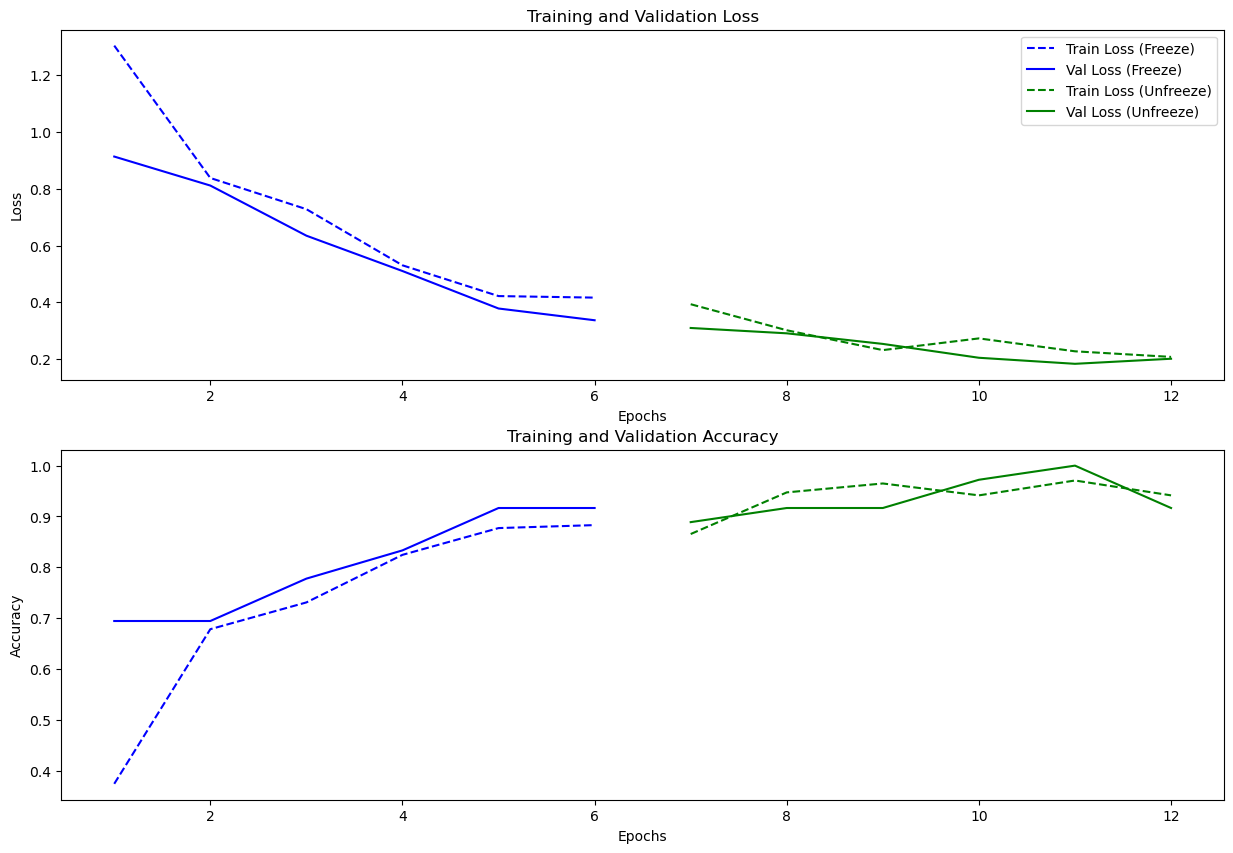

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Parameters
num_classes = 4
batch_size = 8
learning_rate = 0.001
num_epochs = 6  # Example, adjust as needed

# Data transforms with augmentation for training
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Data transforms for validation and testing
eval_transforms = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Modify this to point to your dataset directory
data_dir = "C:\\Users\\Ilmu Komputer\\OneDrive\\Desktop\\4 dataset\\dataset"

# Load the full dataset
full_dataset = datasets.ImageFolder(root=data_dir)

# Calculate sizes for train, val, test splits
num_samples = len(full_dataset)
train_size = int(0.7 * num_samples)
val_size = int(0.15 * num_samples)
test_size = num_samples - train_size - val_size

# Split the dataset into train, val, and test
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Apply the transforms
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = eval_transforms
test_dataset.dataset.transform = eval_transforms

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Check class names
class_names = train_dataset.dataset.classes
print("Class names:", class_names)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model MobileNetV2 kustom dengan modifikasi klasifier
class CustomMobileNetV2(nn.Module):
    def __init__(self, num_classes):
        super(CustomMobileNetV2, self).__init__()
        self.mnet = models.mobilenet_v2(pretrained=True)
        self.mnet.classifier = nn.Sequential(
            nn.Linear(1280, num_classes)
        )
        # Freeze feature extractor
        for param in self.mnet.features.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.mnet(x)

# Create the model instance
model = CustomMobileNetV2(num_classes)
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Define EarlyStopping callback
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
    

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
            

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

# Callbacks
early_stopping = EarlyStopping(patience=2)

# Training function
def train_model(model, criterion, optimizer, num_epochs=2):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                data_loader = train_loader
            else:
                model.eval()
                data_loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects.double() / len(data_loader.dataset)

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.cpu().numpy())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.cpu().numpy())

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Check early stopping
            if phase == 'val':
                early_stopping(epoch_loss, model)
                if early_stopping.early_stop:
                    print("Early stopping")
                    break

    return model, train_losses, val_losses, train_accs, val_accs

# Train the model with frozen layers
model, train_losses_freeze, val_losses_freeze, train_accs_freeze, val_accs_freeze = train_model(model, criterion, optimizer, num_epochs=num_epochs)

# Unfreeze the model
for param in model.parameters():
    param.requires_grad = True

# Adjust the learning rate
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

# Reset EarlyStopping with modified patience
early_stopping = EarlyStopping(patience=5)

# Retrain the model with unfrozen layers
model, train_losses_unfreeze, val_losses_unfreeze, train_accs_unfreeze, val_accs_unfreeze = train_model(model, criterion, optimizer, num_epochs=num_epochs)

# Save the model
torch.save(model.state_dict(), 'mobilenetv2_finetuned.pth')

# Testing function
def test_model(model, test_loader):
    model.eval()
    running_corrects = 0

    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

    test_acc = running_corrects.double() / len(test_loader.dataset)
    print('Test Accuracy: {:.4f}'.format(test_acc))



# Plotting the results
plt.figure(figsize=(15, 10))

# Plotting Loss
plt.subplot(2, 1, 1)
plt.plot(range(1, num_epochs + 1), train_losses_freeze, label='Train Loss (Freeze)', color='blue', linestyle='--')
plt.plot(range(1, num_epochs + 1), val_losses_freeze, label='Val Loss (Freeze)', color='blue')
plt.plot(range(num_epochs + 1, num_epochs * 2 + 1), train_losses_unfreeze, label='Train Loss (Unfreeze)', color='green', linestyle='--')
plt.plot(range(num_epochs + 1, num_epochs * 2 + 1), val_losses_unfreeze, label='Val Loss (Unfreeze)', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(2, 1, 2)
plt.plot(range(1, num_epochs + 1), train_accs_freeze, label='Train Acc (Freeze)', color='blue', linestyle='--')
plt.plot(range(1, num_epochs + 1), val_accs_freeze, label='Val Acc (Freeze)', color='blue')
plt.plot(range(num_epochs + 1, num_epochs * 2 + 1), train_accs_unfreeze, label='Train Acc (Unfreeze)', color='green', linestyle='--')
plt.plot(range(num_epochs + 1, num_epochs * 2 + 1), val_accs_unfreeze, label='Val Acc (Unfreeze)', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend



# Test the model
test_model(model, test_loader)


